## 生成标注掩码

In [1]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# 路径设置
image_dir = '/home/a6/vis/LDS/SAM/datasets/images'
json_dir = '/home/a6/vis/LDS/SAM/datasets/json'
output_dir = '/home/a6/vis/LDS/SAM/datasets/masks'
os.makedirs(output_dir, exist_ok=True)

# 遍历所有JSON文件
for json_file in os.listdir(json_dir):
    if json_file.endswith('.json'):
        # 获取对应的PNG文件路径
        base_name = os.path.splitext(json_file)[0]
        png_file = f"{base_name}.png"
        image_path = os.path.join(image_dir, png_file)
        json_path = os.path.join(json_dir, json_file)

        # 读取图像和JSON文件
        image = Image.open(image_path)
        width, height = image.size
        mask = Image.new('L', (width, height), 0)  # 创建掩码图像，背景为0

        # 解析JSON文件
        with open(json_path, 'r') as f:
            data = json.load(f)
            # 先处理非背景标签
            for shape in data['shapes']:
                label = shape['label'].lower()
                if 'background' not in label:  # 处理非背景标签
                    polygon = [(int(point[0]), int(point[1])) for point in shape['points']]
                    if label == 'pore':  # 处理孔隙标签
                        ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)  # 标记为1

            # 处理背景标签
            for shape in data['shapes']:
                label = shape['label'].lower()
                if 'background' in label:  # 处理背景标签
                    polygon = [(int(point[0]), int(point[1])) for point in shape['points']]
                    ImageDraw.Draw(mask).polygon(polygon, outline=0, fill=0)  # 标记为0

        # 保存掩码图像
        mask.save(os.path.join(output_dir, f"{base_name}_mask.png"))

## 微调SAM的图像编码器
### 1. 导入需要的包

In [2]:
import numpy as np
import torch
import json
import os
import matplotlib.pyplot as plt
import cv2
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from segment_anything import sam_model_registry
import torch.nn.functional as F

## 2. 定义SAM模型

In [3]:
model_type = 'vit_l'
checkpoint = '/home/a6/vis/LDS/SAM/weights/sam_vit_l_0b3195.pth'
device = 'cuda:0'

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)

/home/a6/anaconda3/envs/LDS/lib/python3.9/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

### 2. 数据加载

In [4]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, sam_model, mask_size=(256, 256), device='cpu'):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.sam_model = sam_model
        self.mask_size = mask_size
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.device = device

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 读取图像
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_NEAREST)


        # 读取掩码
        mask_file = image_file.replace('.png', '_mask.png')
        mask_path = os.path.join(self.mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, self.mask_size, interpolation=cv2.INTER_NEAREST)

        # 转换为torch tensor
        input_image_torch = torch.as_tensor(image, dtype=torch.float32).to(self.device)
        input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()  # [C, H, W]

        # SAM模型的预处理步骤
        input_image = self.sam_model.preprocess(input_image_torch.to(self.device))

        # 将掩码转换为torch tensor
        mask = torch.as_tensor(mask, dtype=torch.long).to(self.device)  # 掩码为单通道

        return input_image, mask

# 设置路径
image_dir = '/home/a6/vis/LDS/SAM/datasets/images'
mask_dir = '/home/a6/vis/LDS/SAM/datasets/masks'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建数据集和数据加载器
dataset = SegmentationDataset(image_dir, mask_dir, sam_model, device=device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 测试数据加载器
for i, (images, masks) in enumerate(dataloader):
    print(f'Batch {i}:')
    print(f'Images shape: {images.shape}')  # 应为 [B, 1, C, H, W]
    print(f'Masks shape: {masks.shape}')    # 应为 [B, H, W]
    print(f'Mask unique values: {torch.unique(masks)}')  # 输出掩码中的唯一值
    break

Batch 0:
Images shape: torch.Size([1, 3, 1024, 1024])
Masks shape: torch.Size([1, 256, 256])
Mask unique values: tensor([0, 1], device='cuda:0')


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义损失函数
loss_fn = nn.MSELoss()
# 训练循环
sam_model.train()
num_epochs = 50

# 现在我们只会优化图像编码器的最后一层
optimizer = torch.optim.Adam(sam_model.image_encoder.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    total_loss = 0  # 累加每个batch的损失
    num_batches = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # 前向传播：获取图像嵌入
        image_embedding = sam_model.image_encoder(images)  # B 256 64 64

        # 上采样到 (B, 256, 256, 256)
        upsampled_embedding = F.interpolate(image_embedding, size=(256, 256), mode='bilinear', align_corners=False)

        # 求通道均值 (B, 1, 256, 256)
        mean_embedding = upsampled_embedding.mean(dim=1, keepdim=True)

        # 计算损失
        loss = loss_fn(mean_embedding, masks.float())

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累加损失
        total_loss += loss.item()
        num_batches += 1

    # 计算平均损失
    avg_loss = total_loss / num_batches
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

print("训练完成")


/home/a6/anaconda3/envs/LDS/lib/python3.9/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Average Loss: 0.0407


In [ ]:
# 假设 sam_model 是你的模型实例
torch.save(sam_model.state_dict(), 'sam_model.pth')


Mean Embedding Max Value: 0.250654935836792
Mean Embedding Min Value: -0.011268755421042442


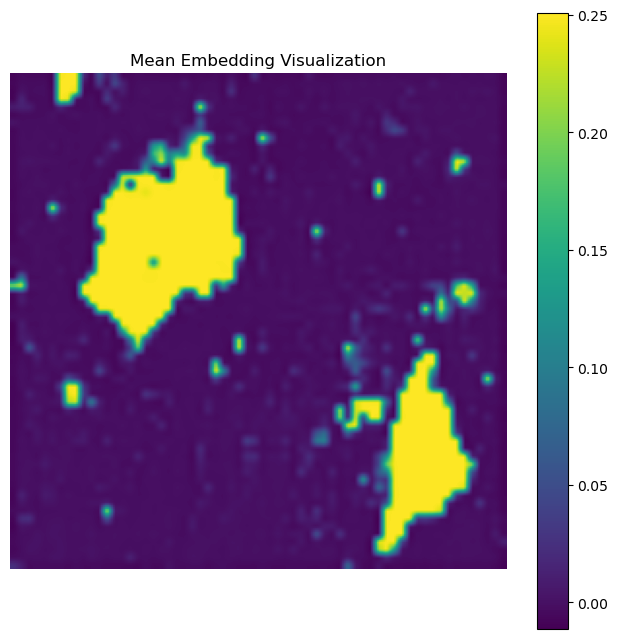

In [ ]:
import numpy as np
import torch
import json
import os
import matplotlib.pyplot as plt
import cv2
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from segment_anything import sam_model_registry
import torch.nn.functional as F

# 设置参数
model_type = 'vit_l'
checkpoint = '/home/a6/vis/LDS/SAM/sam_model.pth'
device = 'cuda:0'
image_path = '/home/a6/vis/LDS/SAM/M201-70m2-.jpg'  # 替换为你的图像路径

# 加载模型
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.eval()  # 切换模型到评估模式

# 加载和预处理图像
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_NEAREST)

# 转换为 torch 张量并预处理
input_image_torch = torch.as_tensor(image, dtype=torch.float32).to(device)
input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()  # [C, H, W]
transformed_image = input_image_torch[None, :, :, :]  # 增加 batch 维度
input_image = sam_model.preprocess(transformed_image)

# 获取图像嵌入
with torch.no_grad():  # 关闭梯度计算
    image_embedding = sam_model.image_encoder(input_image)

# 上采样到 (1, 256, 256)
upsampled_embedding = F.interpolate(image_embedding, size=(256, 256), mode='bilinear', align_corners=False)
mean_embedding = upsampled_embedding.mean(dim=1, keepdim=True)  # 求通道均值

# 将嵌入数据移到CPU以进行可视化
mean_embedding_cpu = mean_embedding.squeeze().cpu().numpy()  # 移除 batch 维度并转换为 numpy
# 获取 mean_embedding_cpu 的最大值和最小值
max_value = mean_embedding_cpu.max()
min_value = mean_embedding_cpu.min()

# 输出最大值和最小值
print(f"Mean Embedding Max Value: {max_value}")
print(f"Mean Embedding Min Value: {min_value}")

# 可视化
plt.figure(figsize=(8, 8))
plt.imshow(mean_embedding_cpu, cmap='viridis')
plt.colorbar()
plt.title('Mean Embedding Visualization')
plt.axis('off')
plt.show()
